## CycleGAN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Set up the input pipeline

In [2]:
pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ax2k2gx8
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-ax2k2gx8
  Created wheel for tensorflow-examples: filename=tensorflow_examples-8cb3e3adf9808caa7e3612297742a72b9be9d634_-py3-none-any.whl size=268413 sha256=0287536e0e6327864b1cfd3c554b95f70aadb43daba0ab2d18067b43bf890dde
  Stored in directory: /tmp/pip-ephem-wheel-cache-puvd6ucx/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [3]:
import tensorflow as tf

In [4]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

### 2. Input Pipeline

This notebook trains a model to translate from images of apples, to images of oranges.

As mentioned in the paper, apply random jittering and mirroring to the training dataset. These are some of the image augmentation techniques that avoids overfitting.

In random jittering, the image is resized to 286 x 286 and then randomly cropped to 256 x 256.
In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [5]:
dataset, metadata = tfds.load('cycle_gan/apple2orange',
                              with_info=True, as_supervised=True)

train_apple, train_orange = dataset['trainA'], dataset['trainB']
test_apple, test_orange = dataset['testA'], dataset['testB']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incompleteVMZBV2/cycle_gan-trainA.tfrecord


  0%|          | 0/995 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incompleteVMZBV2/cycle_gan-trainB.tfrecord


  0%|          | 0/1019 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incompleteVMZBV2/cycle_gan-testA.tfrecord


  0%|          | 0/266 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incompleteVMZBV2/cycle_gan-testB.tfrecord


  0%|          | 0/248 [00:00<?, ? examples/s]

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0. Subsequent calls will reuse this data.


In [6]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [7]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [8]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [9]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [10]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [11]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

### 3. Generate data with augmentation techniques 

In [12]:
train_apple = train_apple.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_orange = train_orange.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_apple = test_apple.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_orange = test_orange.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
sample_apple = next(iter(train_apple))
sample_orange = next(iter(train_orange))

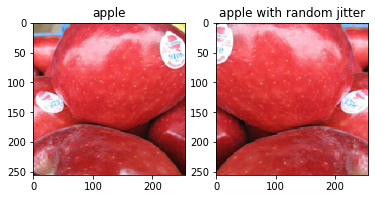

In [14]:
plt.subplot(121)
plt.title('apple')
plt.imshow(sample_apple[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('apple with random jitter')
plt.imshow(random_jitter(sample_apple[0]) * 0.5 + 0.5)

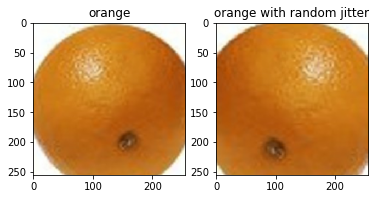

In [15]:
plt.subplot(121)
plt.title('orange')
plt.imshow(sample_orange[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('orange with random jitter')
plt.imshow(random_jitter(sample_orange[0]) * 0.5 + 0.5)

### 4. Import and reuse the Pix2Pix models

In [16]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

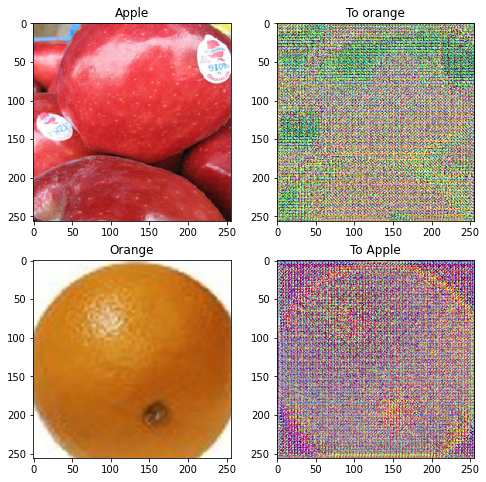

In [17]:
to_orange = generator_g(sample_apple)
to_apple = generator_f(sample_orange)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_apple, to_orange, sample_orange, to_apple]
title = ['Apple', 'To orange', 'Orange', 'To Apple']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

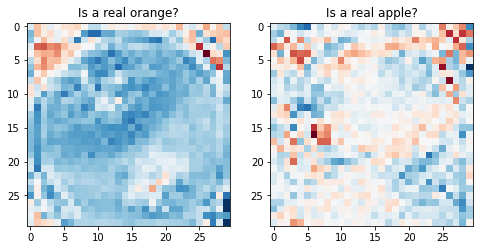

In [18]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real orange?')
plt.imshow(discriminator_y(sample_orange)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real apple?')
plt.imshow(discriminator_x(sample_apple)[0, ..., -1], cmap='RdBu_r')

plt.show()

### 5. Loss Functions

In [19]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [21]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [22]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [23]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [24]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### 6. Checkpoints

In [25]:
checkpoint_path = "/content/drive/MyDrive/Lab2/part1/checkpoint"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [ ]:
EPOCHS = 40

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

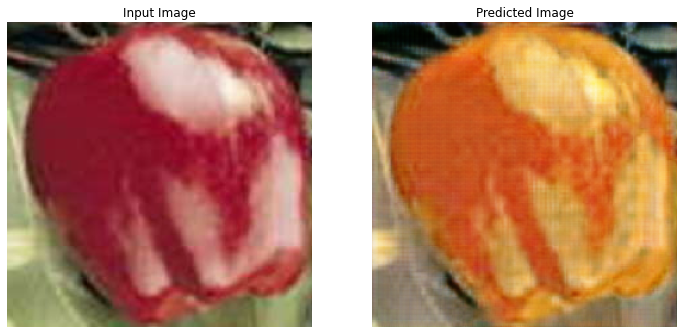

Saving checkpoint for epoch 40 at /content/drive/MyDrive/Lab2/part1/checkpoint/ckpt-8
Time taken for epoch 40 is 236.0954954624176 sec



In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_apple, train_orange)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_apple)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

## 7. Generate Images and save to directory

In [37]:
def generate_images_fake(model, test_input, number):
  prediction = model(test_input)  
  tf.keras.utils.save_img('/content/drive/MyDrive/Lab2/part1/temp/predicted/predicted_image{:04d}.jpg'.format(number), prediction[0], scale=True)
  

In [38]:
number=0
for inp in test_apple.take(200):
  generate_images_fake(generator_g, inp, number)
  number+=1

for inp in train_apple.take(700):
  generate_images_fake(generator_g, inp, number)
  number+=1

In [41]:
#Saving 900 original images
def generate_images_original(test_input, number):  
  tf.keras.utils.save_img('/content/drive/MyDrive/Lab2/part1/temp/original/original_image{:04d}.jpg'.format(number), test_input[0], scale=True)

In [42]:
number=0
for inp in test_orange.take(200):
  generate_images_original(inp, number)
  number+=1

for inp in train_orange.take(700):
  generate_images_original(inp, number)
  number+=1

## Step 3. Utilize a deep learning model trained on the images produced from your GAN and the original dataset. Train this model to discriminate between original and CycleGAN modified images.
This step is performed in a different notebook and cells are pasted in this notebook


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
import PIL
import PIL.Image
import numpy as np
import tensorflow as tf
import keras
import numpy as np
from keras import layers
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

### Loading the data

In [3]:
from pathlib import Path
data_dir=Path('/content/drive/MyDrive/Lab2/part1/temp')

In [4]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

1800


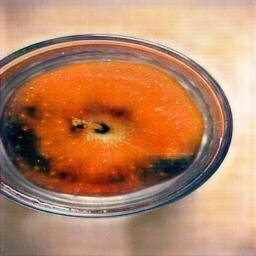

In [5]:
predicted = list(data_dir.glob('predicted/*'))
PIL.Image.open(str(predicted[0]))

In [6]:
from keras.preprocessing.image import ImageDataGenerator

In [17]:
#rescaling the data and specifying validation split.
datagen = ImageDataGenerator(rescale=1./255,
        validation_split = 0.2)

In [18]:
#train data
traingenerator = datagen.flow_from_directory(
        data_dir,
        target_size=(256, 256),
        batch_size=1440,
        subset='training')

Found 1440 images belonging to 2 classes.


In [19]:
testgenerator = datagen.flow_from_directory(
        data_dir,
        target_size=(256, 256),
        batch_size=360,
        subset='validation')

Found 360 images belonging to 2 classes.


### From Datagen object to arrays 

In [20]:
x_train,y_train = next(traingenerator)
x_test,y_test = next(testgenerator)

In [21]:
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

print('Training data shape : ', x_train.shape, y_train.shape)

print('Testing data shape : ', x_test.shape, y_test.shape)

Training data shape :  (1440, 256, 256, 3) (1440, 2)
Testing data shape :  (360, 256, 256, 3) (360, 2)


In [22]:
print('Total number of classes : ', len(y_test[0]))

Total number of classes :  2


Text(0.5, 1.0, 'Ground Truth : [1. 0.]')

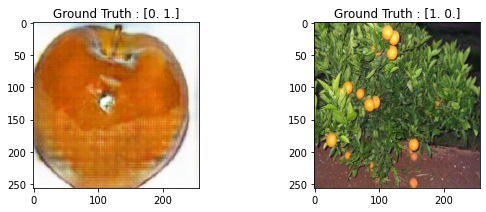

In [23]:
plt.figure(figsize=[8,8])

# Display the first image in training data
plt.subplot(121)
plt.subplots_adjust(wspace = 0.7)
plt.imshow(x_train[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(y_train[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(x_test[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(y_test[0]))

In [24]:
x_train.dtype,x_test.dtype

(dtype('float32'), dtype('float32'))

### Data Augmentaion 

In [26]:
#data augmentation which will generate similar images to the given data 

datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                             height_shift_range=0.1, horizontal_flip=True)
train_it = datagen.flow(x_train, y_train, batch_size=64)

### Model Defination

In [27]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',patience=11, restore_best_weights=True)

### Training the model 

In [31]:
history = model.fit(train_it, epochs=100,  validation_data=(x_test,y_test), callbacks=[es])

Epoch 1/100
23/23 [==============================] - 38s 893ms/step - loss: 1.3119 - accuracy: 0.5160 - val_loss: 5.6185 - val_accuracy: 0.4944
Epoch 2/100
23/23 [==============================] - 19s 821ms/step - loss: 1.0318 - accuracy: 0.5326 - val_loss: 1.6298 - val_accuracy: 0.5194
Epoch 3/100
23/23 [==============================] - 19s 826ms/step - loss: 1.0784 - accuracy: 0.5347 - val_loss: 1.0302 - val_accuracy: 0.4889
Epoch 4/100
23/23 [==============================] - 19s 813ms/step - loss: 0.9483 - accuracy: 0.5556 - val_loss: 1.3670 - val_accuracy: 0.4611
Epoch 5/100
23/23 [==============================] - 19s 820ms/step - loss: 0.9097 - accuracy: 0.5653 - val_loss: 1.1292 - val_accuracy: 0.4861
Epoch 6/100
23/23 [==============================] - 19s 841ms/step - loss: 0.8636 - accuracy: 0.5528 - val_loss: 1.0099 - val_accuracy: 0.5250
Epoch 7/100
23/23 [==============================] - 20s 840ms/step - loss: 0.8243 - accuracy: 0.5722 - val_loss: 1.1103 - val_accuracy:

### Evaluating the CNN Model 

In [32]:
eval=model.evaluate(x_test, y_test)

12/12 [==============================] - 0s 31ms/step - loss: 0.2052 - accuracy: 0.9167


In [36]:
y_pred= model.predict(x_test)

In [42]:
y_test_=np.argmax(y_test, axis=1)
y_pred_=np.argmax(y_pred, axis=1)

### Confusion Matrix 

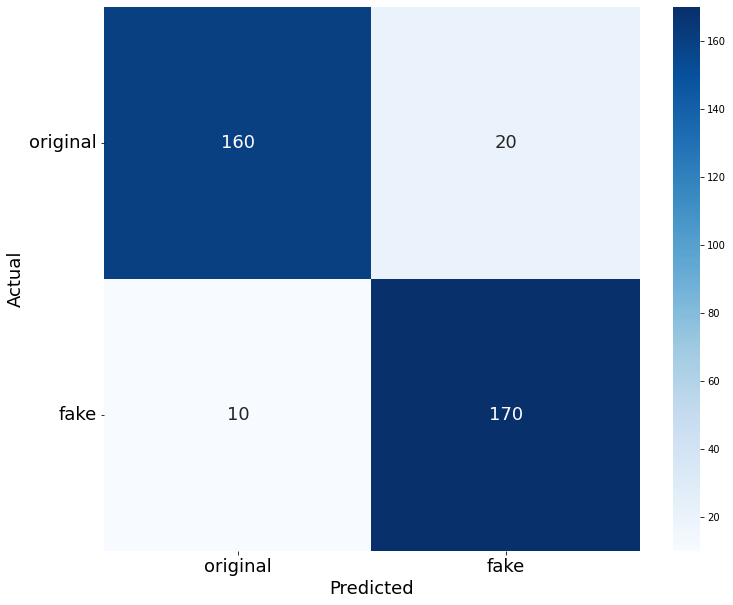

In [43]:
from sklearn.metrics import confusion_matrix
target_names=['original','fake']
cm=confusion_matrix(y_test_, y_pred_)

import seaborn as sns
plt.figure(figsize=(12,10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues',annot_kws={"size": 18})
ax.xaxis.set_ticklabels(target_names, rotation=0, fontsize=18)
ax.yaxis.set_ticklabels(target_names, rotation=0,fontsize=18)
ax.set_ylabel('Actual',fontsize=18)
ax.set_xlabel('Predicted',fontsize=18);

### Comments

The model achieved an accuracy score of 91.67% which means that the images generated using cycleGAN were not close to the real images. The accuracy would have been even better if we had more data to train the model on